# Before-After "Show Card" Experiment

- The EEG recordings for a single patient are split along the time axis at the "Show Card" event. This yields 2 classes: "Before" (Class 0) and "After" (Class 1).

- We demonstrate the efficacy of MTS-MORF in classifying multivariate time-series into these two classes.

In [1]:
cd ../../

/workspaces/research/seeg localization/SPORF


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
from fastdtw import fastdtw
from mne_bids.read import read_raw_bids
from mne_bids.write import make_bids_basename
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")

# subject identifiers
subject = "efri07"
session = "efri"
task = "war"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_fname = make_bids_basename(subject=subject, session=session, task=task,
                                acquisition=acquisition, run=run, suffix=f"{kind}.vhdr")

## Load in raw data

In [4]:
from mtsmorf.io.read import get_trial_info

raw = read_raw_bids(bids_fname, bids_root)

behav_tsv, events_tsv = get_trial_info(bids_fname, bids_root)

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 162 trials, there were 162 successful trials in sub-efri07_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr.


In [5]:
# fetch labels
labels, trial_ids = read_label(bids_fname, bids_root, trial_id=None, label_keyword="subject_card")

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where(np.isnan(labels))[0]
y = np.delete(labels, unsuccessful_trial_inds)

Out of 162 trials, there were 162 successful trials in sub-efri07_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr.


In [6]:
# read dataset as an epoch
tmin, tmax = (-0.2, 0.2)

# get EEG data
epochs = read_dataset(bids_fname, bids_root, tmin=tmin, tmax=tmax)
epochs = epochs.drop(unsuccessful_trial_inds)
epochs.load_data()
X = epochs.get_data()

# get shape of data
ntrials, nchs, nsteps = X.shape

# check there are equal number of trials and labels
assert(ntrials == labels.shape[0]), "Unequal number of trials and labels"

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 162 trials, there were 162 successful trials in sub-efri07_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr.
Used Annotations descriptions: ['Reserved (End Trial)', 'Reserved (Start Trial)', 'acquire target', 'bet 20', 'bet 5', 'fixation', 'hide reward', 'show bet', 'show card', 'show card results', 'show reward1', 'show reward2', 'start move']
Not setting metadata
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
Dropped 0 epochs: 
Loading data for 162 events and 801 origina

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

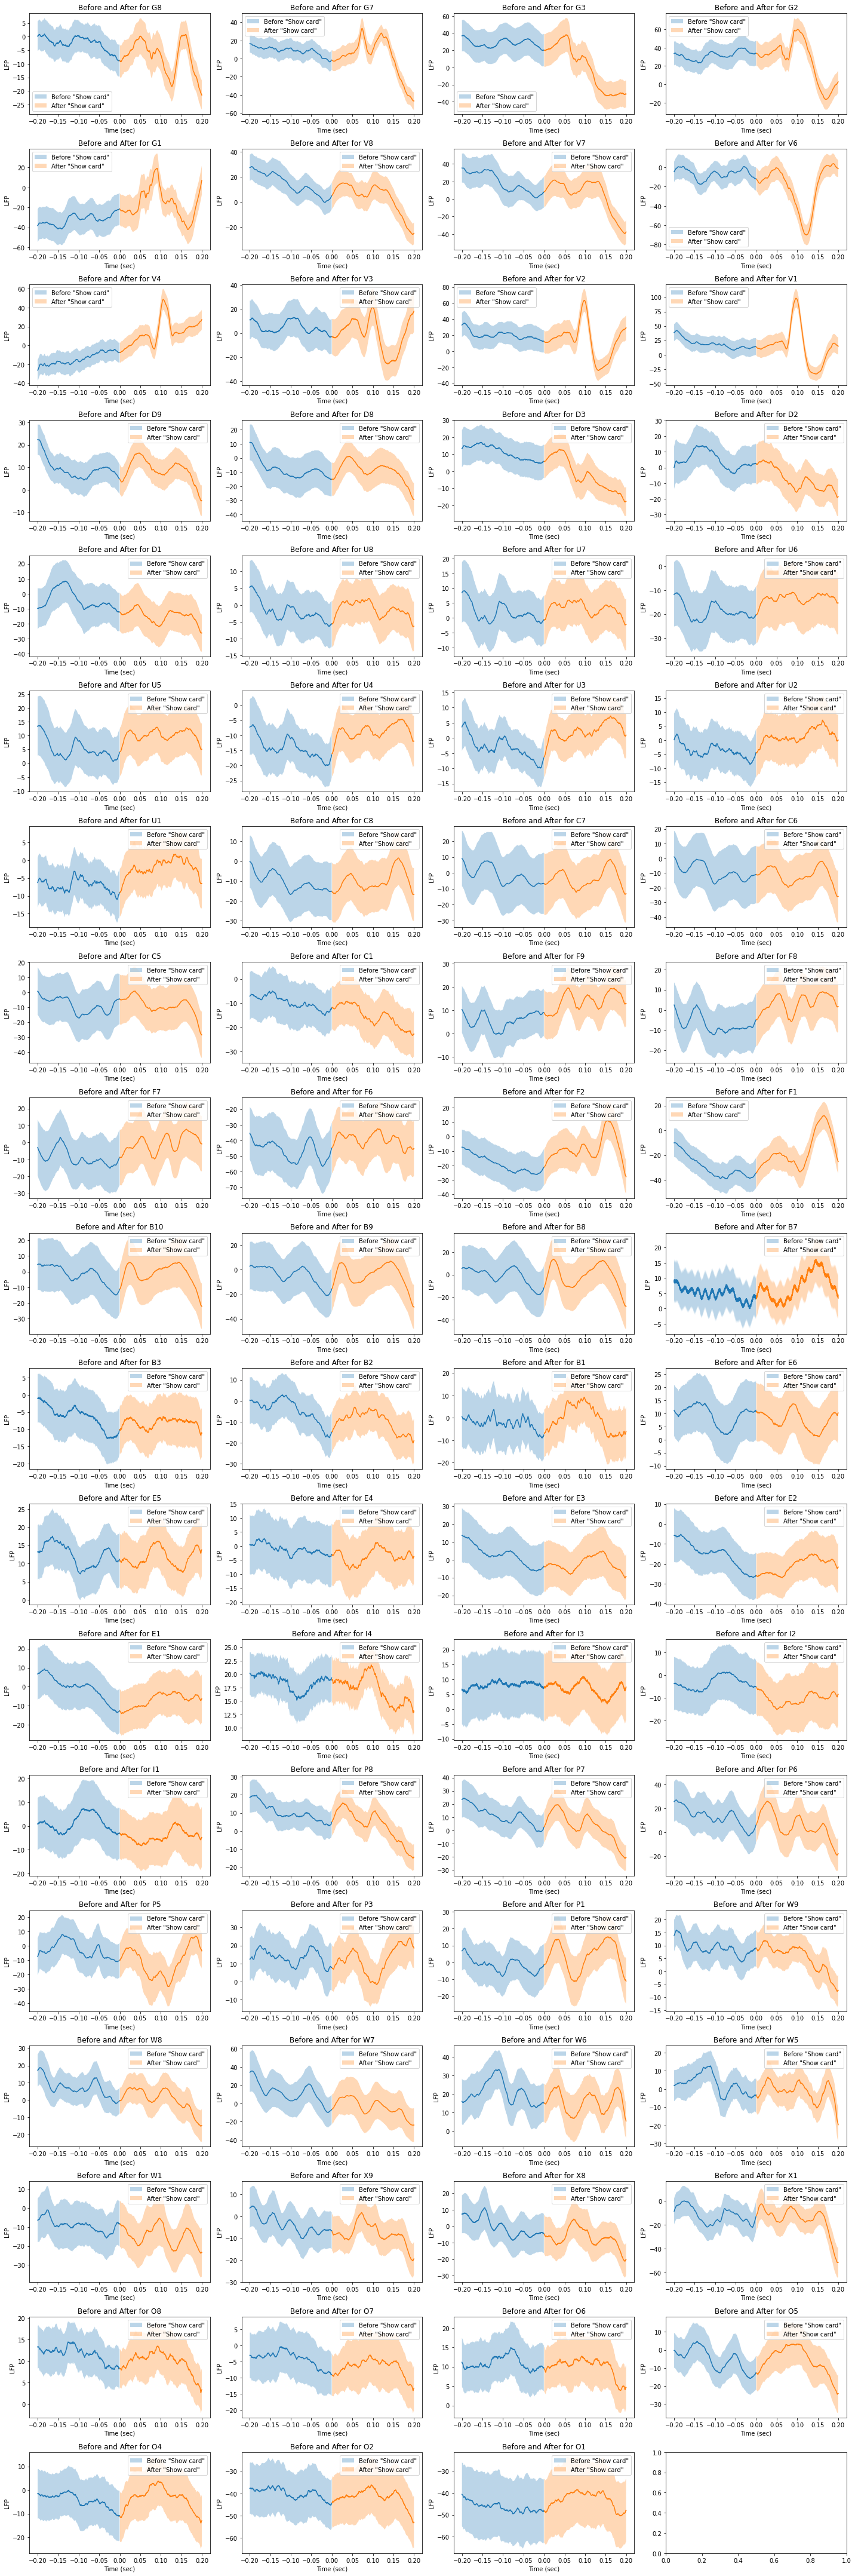

In [14]:
t = epochs.times
before = X[:, :, t < 0]
after = X[:, :, t > 0]

fig, axs = plt.subplots(nrows=int(np.ceil(nchs / 4)), ncols=4, figsize=(20, 60))
axs = axs.flatten()

for i, ch in enumerate(epochs.ch_names):

    ax = axs[i]
    avg_signal0, lower_bound0, upper_bound0 = mean_confidence_interval(before[:, i])
    avg_signal1, lower_bound1, upper_bound1 = mean_confidence_interval(after[:, i])

    sns.lineplot(t[t < 0], avg_signal0, ax=ax)
    ax.fill_between(t[t < 0], lower_bound0, upper_bound0, alpha=0.3, label='Before "Show card"')

    sns.lineplot(t[t > 0], avg_signal1, ax=ax)
    ax.fill_between(t[t > 0], lower_bound1, upper_bound1, alpha=0.3, label='After "Show card"')

    ax.set(
        xlabel='Time (sec)',
        ylabel='LFP',
        title=f'Before and After for {ch}')
    ax.legend()

fig.tight_layout();

In [30]:
data = np.vstack([before, after])
labels = np.vstack([np.zeros((len(before), 1)), np.ones((len(after), 1))])
perm = np.random.permutation(len(data))

data = data[perm]
labels = labels[perm]

In [ ]:
from rerf.rerfClassifier import rerfClassifier

data = data.reshape(data.shape[0], -1)
clf = rerfClassifier(n_estimators=100)
clf.fit(data, labels)
preds = clf.predict(data)
print(np.mean(preds == labels))